### Import the required libraries and modules:

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/BV_OD_Drive

Mounted at /content/gdrive
/content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/BV_OD_Drive


### Unzip the data:

In [3]:
# !unzip new_data.zip

### Construct the Model:

In [4]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, strides=2):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D(strides)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, strides=2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2]):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters[0], strides=strides[0])
    s2, p2 = encoder_block(p1, num_filters[1], strides=strides[1])
    s3, p3 = encoder_block(p2, num_filters[2], strides=strides[2])
    s4, p4 = encoder_block(p3, num_filters[3], strides=strides[3])

    b1 = conv_block(p4, num_filters[4])

    d1 = decoder_block(b1, s4, num_filters[3], strides=strides[3])
    d2 = decoder_block(d1, s3, num_filters[2], strides=strides[2])
    d3 = decoder_block(d2, s2, num_filters[1], strides=strides[1])
    d4 = decoder_block(d3, s1, num_filters[0], strides=strides[0])

    outputs = Conv2D(2, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Adding the Metrics:

In [5]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def DiceBCELoss(y_true, y_pred):

    inputs = tf.keras.layers.Flatten()(y_true)
    targets = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(inputs * targets)
    dice_loss = 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    BCE = tf.keras.losses.BinaryCrossentropy()
    Dice_BCE = BCE(inputs, targets) + dice_loss

    return Dice_BCE

### Training the Model:

In [6]:
W = 512
H = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512, 3)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:2] # Discard the last channel 

    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 2])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [7]:
# """ Seeding """
# np.random.seed(42)
# tf.random.set_seed(42)

# """ Directory to save files """
# create_dir("files")

# """ Hyperparameters """
# batch_size = 2
# lr = 1e-4
# num_epochs = 50
# model_path = os.path.join("files", "model_1024.h5")
# csv_path = os.path.join("files", "data_1024.csv")

# """ Dataset """
# dataset_path = "new_data"
# train_path = os.path.join(dataset_path, "train")
# valid_path = os.path.join(dataset_path, "test")

# train_x, train_y = load_data(train_path)
# train_x, train_y = shuffling(train_x, train_y)
# valid_x, valid_y = load_data(valid_path)

# print(f"Train: {len(train_x)} - {len(train_y)}")
# print(f"Valid: {len(valid_x)} - {len(valid_y)}")

# train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
# valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

# train_steps = len(train_x)//batch_size
# valid_setps = len(valid_x)//batch_size

# if len(train_x) % batch_size != 0:
#     train_steps += 1
# if len(valid_x) % batch_size != 0:
#     valid_setps += 1

# """ Model """
# model_1024 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[1, 2, 2, 2])

# model_1024.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

# callbacks = [
#     ModelCheckpoint(model_path, verbose=1, save_best_only=True),
#     ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
#     CSVLogger(csv_path),
#     TensorBoard(),
#     EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
# ]

# model_1024.fit(
#     train_dataset,
#     epochs=num_epochs,
#     validation_data=valid_dataset,
#     steps_per_epoch=train_steps,
#     validation_steps=valid_setps,
#     callbacks=callbacks
# )

### Evaluate The Model:

In [8]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
# from metrics import dice_loss, dice_coef, iou
# from utils import get_filenames_sorted

In [9]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:2] # Discard the last channel 
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255

    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)

In [11]:
from copy import deepcopy

data_dir = "new_data"
od_channel, bv_channel = 0, 1

model_dir = "files"
threshold = 0.1

od_result_dir = f"files_demo_od_{threshold}_1024"
bv_result_dir = f"files_demo_bv_{threshold}_1024"

create_dir(od_result_dir)
create_dir(bv_result_dir)

""" Load the model """
model_file_name = f"{model_dir}/model_1024.h5"
print(model_file_name)
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_coef_OD': dice_coef_OD, 'dice_coef_MA': dice_coef_MA, 'dice_loss': dice_loss}):
model = tf.keras.models.load_model(model_file_name, compile = False)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
# test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE_BV, SCORE_OD = [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_prob = deepcopy(y_pred)
    y_pred = y_pred > threshold
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_bv = f"{bv_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_bv, bv_channel)


#     """ Calculate the bv metrics """
    bv_pred = y_pred[:, :, bv_channel].flatten()
    bv_pred_prob = y_pred_prob[:, :, bv_channel].flatten()
    bv_gt = y[:, :, bv_channel].flatten()
    acc_value = accuracy_score(bv_gt > threshold, bv_pred>threshold)
    f1_value = f1_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > threshold) & (bv_pred > threshold)) / np.sum(bv_gt > threshold)
    precision_value = precision_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(bv_gt > threshold, bv_pred_prob)
    auc_bv = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_bv, tpr_bv, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_BV.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])

#     """ Calculate the od metrics """
    bv_pred = y_pred[:, :, od_channel].flatten()
    bv_pred_prob = y_pred_prob[:, :, bv_channel].flatten()
    bv_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(bv_gt > threshold, bv_pred>threshold)
    f1_value = f1_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    spec_value = recall_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary", pos_label=0)

    recall_computed = np.sum((bv_gt > threshold) & (bv_pred > threshold)) / np.sum(bv_gt > threshold)
    precision_value = precision_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(bv_gt > threshold, bv_pred_prob)
    # auc_od = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    # fpr_od, tpr_od, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])
    
print("\n")
for SCORE in [SCORE_OD, SCORE_BV]:
    if SCORE == SCORE_OD:
        print("****** OD ******Metrics")
    else:
        print("****** BV ******Metrics")
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Threshold:", threshold)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f} (dice score)")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")
    print(f"AUC: {score[5]:0.5f}")
    print(f"Specificity: {score[6]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{od_result_dir}/score.csv")
    else:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{bv_result_dir}/score.csv")
    print("\n")

files/model_1024.h5


  0%|          | 0/20 [00:00<?, ?it/s]

01_test
255 1.0
 saving result files_demo_od_0.1_1024/01_test.png
 saving result files_demo_bv_0.1_1024/01_test.png


  5%|▌         | 1/20 [00:02<00:48,  2.56s/it]

02_test
255 1.0
 saving result files_demo_od_0.1_1024/02_test.png
 saving result files_demo_bv_0.1_1024/02_test.png


 10%|█         | 2/20 [00:05<00:52,  2.89s/it]

03_test
255 1.0
 saving result files_demo_od_0.1_1024/03_test.png
 saving result files_demo_bv_0.1_1024/03_test.png


 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]

04_test
255 1.0
 saving result files_demo_od_0.1_1024/04_test.png
 saving result files_demo_bv_0.1_1024/04_test.png


 20%|██        | 4/20 [00:09<00:38,  2.39s/it]

05_test
255 1.0
 saving result files_demo_od_0.1_1024/05_test.png
 saving result files_demo_bv_0.1_1024/05_test.png


 25%|██▌       | 5/20 [00:11<00:33,  2.21s/it]

06_test
255 1.0
 saving result files_demo_od_0.1_1024/06_test.png
 saving result files_demo_bv_0.1_1024/06_test.png


 30%|███       | 6/20 [00:13<00:29,  2.14s/it]

07_test
255 1.0
 saving result files_demo_od_0.1_1024/07_test.png
 saving result files_demo_bv_0.1_1024/07_test.png


 35%|███▌      | 7/20 [00:16<00:29,  2.23s/it]

08_test
255 1.0
 saving result files_demo_od_0.1_1024/08_test.png
 saving result files_demo_bv_0.1_1024/08_test.png


 40%|████      | 8/20 [00:18<00:26,  2.17s/it]

09_test
255 1.0
 saving result files_demo_od_0.1_1024/09_test.png
 saving result files_demo_bv_0.1_1024/09_test.png


 45%|████▌     | 9/20 [00:20<00:24,  2.18s/it]

10_test
255 1.0
 saving result files_demo_od_0.1_1024/10_test.png
 saving result files_demo_bv_0.1_1024/10_test.png


 50%|█████     | 10/20 [00:22<00:22,  2.23s/it]

11_test
255 1.0
 saving result files_demo_od_0.1_1024/11_test.png
 saving result files_demo_bv_0.1_1024/11_test.png


 55%|█████▌    | 11/20 [00:25<00:20,  2.26s/it]

12_test
255 1.0
 saving result files_demo_od_0.1_1024/12_test.png
 saving result files_demo_bv_0.1_1024/12_test.png


 60%|██████    | 12/20 [00:27<00:18,  2.27s/it]

13_test
255 1.0
 saving result files_demo_od_0.1_1024/13_test.png
 saving result files_demo_bv_0.1_1024/13_test.png


 65%|██████▌   | 13/20 [00:30<00:18,  2.65s/it]

14_test
255 1.0
 saving result files_demo_od_0.1_1024/14_test.png
 saving result files_demo_bv_0.1_1024/14_test.png


 70%|███████   | 14/20 [00:33<00:15,  2.63s/it]

15_test
255 1.0
 saving result files_demo_od_0.1_1024/15_test.png
 saving result files_demo_bv_0.1_1024/15_test.png


 75%|███████▌  | 15/20 [00:35<00:12,  2.45s/it]

16_test
255 1.0
 saving result files_demo_od_0.1_1024/16_test.png
 saving result files_demo_bv_0.1_1024/16_test.png


 80%|████████  | 16/20 [00:37<00:09,  2.31s/it]

17_test
255 1.0
 saving result files_demo_od_0.1_1024/17_test.png
 saving result files_demo_bv_0.1_1024/17_test.png


 85%|████████▌ | 17/20 [00:39<00:06,  2.20s/it]

18_test
255 1.0
 saving result files_demo_od_0.1_1024/18_test.png
 saving result files_demo_bv_0.1_1024/18_test.png


 90%|█████████ | 18/20 [00:41<00:04,  2.10s/it]

19_test
255 1.0
 saving result files_demo_od_0.1_1024/19_test.png
 saving result files_demo_bv_0.1_1024/19_test.png


 95%|█████████▌| 19/20 [00:43<00:02,  2.07s/it]

20_test
255 1.0
 saving result files_demo_od_0.1_1024/20_test.png
 saving result files_demo_bv_0.1_1024/20_test.png


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]




****** OD ******Metrics
Threshold: 0.1
Accuracy: 0.99277
F1: 0.75059 (dice score)
Jaccard: 0.65733
Recall: 0.87372
Precision: 0.77264
AUC: 0.87372
Specificity: 29.62276


****** BV ******Metrics
Threshold: 0.1
Accuracy: 0.95889
F1: 0.80313 (dice score)
Jaccard: 0.67335
Recall: 0.74930
Precision: 0.87674
AUC: 0.74930
Specificity: 2524.15782




In [ ]:
%cd /content/gdrive/MyDrive/1_All_Computations/BV_OD_EX_DiceBCE

from copy import deepcopy
from utils import get_filenames_sorted

H = 512
W = 768

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:3] # Discard the last channel 
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255

    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)

data_dir = "new_data_augment"
od_channel, he_channel, ex_channel = 0, 1, 2

threshold = 0.25

od_result_dir = f"files_demo_bv_{threshold}"
he_result_dir = f"files_demo_od_{threshold}"
ex_result_dir = f"files_demo_ex_{threshold}"

create_dir(od_result_dir)
create_dir(he_result_dir)
create_dir(ex_result_dir)

model_dir = "files"

""" Load the model """
model_file_name = f"{model_dir}/model.h5"
print(model_file_name)
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
model = tf.keras.models.load_model(model_file_name, compile=False)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

""" Make the prediction and calculate the metrics values """
SCORE_OD, SCORE_HE, SCORE_EX = [], [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_prob = deepcopy(y_pred)
    y_pred = y_pred > threshold
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_he = f"{he_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_he, he_channel)

    save_image_path_ex = f"{ex_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_ex, ex_channel)

    #     """ Calculate the OD metrics """
    ma_pred = y_pred[:, :, od_channel].flatten()
    ma_pred_prob = y_pred_prob[:, :, od_channel].flatten()
    ma_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(ma_gt > threshold, ma_pred>threshold)
    f1_value = f1_score(ma_gt > threshold, ma_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(ma_gt > threshold, ma_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(ma_gt > threshold, ma_pred>threshold, labels=[0, 1], average="binary")
    recall_computed = np.sum((ma_gt > threshold) & (ma_pred > threshold)) / np.sum(ma_gt > threshold)
    precision_value = precision_score(ma_gt > threshold, ma_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(ma_gt > threshold, ma_pred_prob)
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])

    #     """ Calculate the HE metrics """
    bv_pred = y_pred[:, :, he_channel].flatten()
    bv_pred_prob = y_pred_prob[:, :, he_channel].flatten()
    bv_gt = y[:, :, he_channel].flatten()
    acc_value = accuracy_score(bv_gt > threshold, bv_pred>threshold)
    f1_value = f1_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > threshold) & (bv_pred > threshold)) / np.sum(bv_gt > threshold)
    precision_value = precision_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(bv_gt > threshold, bv_pred_prob)
    auc_od = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_od, tpr_od, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_HE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])

    #     """ Calculate the EX metrics """
    he_pred = y_pred[:, :, ex_channel].flatten()
    he_pred_prob = y_pred_prob[:, :, ex_channel].flatten()
    he_gt = y[:, :, ex_channel].flatten()
    acc_value = accuracy_score(he_gt > threshold, he_pred>threshold)
    f1_value = f1_score(he_gt > threshold, he_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(he_gt > threshold, he_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(he_gt > threshold, he_pred>threshold, labels=[0, 1], average="binary")
    recall_computed = np.sum((he_gt > threshold) & (he_pred > threshold)) / np.sum(he_gt > threshold)
    precision_value = precision_score(ma_gt > threshold, ma_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(he_gt > threshold, he_pred_prob)
    auc_ex = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_ex, tpr_ex, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_EX.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])
    
print("\n")

for SCORE in [SCORE_OD, SCORE_HE, SCORE_EX]:
    if SCORE == SCORE_OD:
        print("****** BV Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Threshold:", threshold)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")
        print(f"AUC: {score[5]:0.5f}")

    elif SCORE == SCORE_HE:
        print("****** OD Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Threshold:", threshold)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")
        print(f"AUC: {score[5]:0.5f}")

    else:
        print("****** EX Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Threshold:", threshold)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")
        print(f"AUC: {score[5]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{od_result_dir}/score.csv")

    elif SCORE == SCORE_HE:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{he_result_dir}/score.csv")
    else:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{ex_result_dir}/score.csv")
    print("\n")

In [ ]:
%cd /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment
# !unzip new_data_augment.zip

In [ ]:
H = 512
W = 768

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:3] # Discard the last channel 
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255

    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)

model_dir="/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files"

data_dir = "new_data_augment"
od_channel, he_channel, ex_channel = 0, 1, 2
# The names are bv_channel, od_channel, fovea_channel = 0, 1, 2. Please rename after run.

od_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files_demo_od"
he_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files_demo_he"
ex_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files_demo_ex"

create_dir(od_result_dir)
create_dir(he_result_dir)
create_dir(ex_result_dir)

""" Load the model """
model_file_name = f"{model_dir}/model.h5"
print(model_file_name)
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model(model_file_name)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

""" Make the prediction and calculate the metrics values """
SCORE_OD, SCORE_HE, SCORE_EX = [], [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_he = f"{he_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_he, he_channel)

    save_image_path_ex = f"{ex_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_ex, ex_channel)


#     """ Calculate the OD metrics """
    ma_pred = y_pred[:, :, od_channel].flatten()
    ma_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(ma_gt > 0.5, ma_pred>0.5)
    f1_value = f1_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((ma_gt > 0.5) & (ma_pred > 0.5)) / np.sum(ma_gt > 0.5)
    precision_value = precision_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])

#     """ Calculate the HE metrics """
    bv_pred = y_pred[:, :, he_channel].flatten()
    bv_gt = y[:, :, he_channel].flatten()
    acc_value = accuracy_score(bv_gt > 0.5, bv_pred>0.5)
    f1_value = f1_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > 0.5) & (bv_pred > 0.5)) / np.sum(bv_gt > 0.5)
    precision_value = precision_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    auc_od2 = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_od2, tpr_od2, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_HE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])

#     """ Calculate the EX metrics """
    he_pred = y_pred[:, :, ex_channel].flatten()
    he_gt = y[:, :, ex_channel].flatten()
    acc_value = accuracy_score(he_gt > 0.5, he_pred>0.5)
    f1_value = f1_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((he_gt > 0.5) & (he_pred > 0.5)) / np.sum(he_gt > 0.5)
    precision_value = precision_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    auc_fovea = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_fovea, tpr_fovea, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_EX.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])
    
print("\n")

for SCORE in [SCORE_OD, SCORE_HE, SCORE_EX]:
    if SCORE == SCORE_OD:
        print("****** BV Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    elif SCORE == SCORE_HE:
        print("****** OD Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    else:
        print("****** Fovea Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{od_result_dir}/score.csv")

    elif SCORE == SCORE_HE:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{he_result_dir}/score.csv")
    else:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{ex_result_dir}/score.csv")
    print("\n")

In [ ]:
H = 512
W = 768

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:3] # Discard the last channel 
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255

    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)

model_dir="/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files"

data_dir = "new_data_augment"
od_channel, he_channel, ex_channel = 0, 1, 2
# The names are bv_channel, od_channel, fovea_channel = 0, 1, 2. Please rename after run.

od_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files_demo_od"
he_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files_demo_he"
ex_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment/files_demo_ex"

create_dir(od_result_dir)
create_dir(he_result_dir)
create_dir(ex_result_dir)

""" Load the model """
model_file_name = f"{model_dir}/model.h5"
print(model_file_name)
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model(model_file_name)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

""" Make the prediction and calculate the metrics values """
SCORE_OD, SCORE_HE, SCORE_EX = [], [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_he = f"{he_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_he, he_channel)

    save_image_path_ex = f"{ex_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_ex, ex_channel)


#     """ Calculate the OD metrics """
    ma_pred = y_pred[:, :, od_channel].flatten()
    ma_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(ma_gt > 0.5, ma_pred>0.5)
    f1_value = f1_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((ma_gt > 0.5) & (ma_pred > 0.5)) / np.sum(ma_gt > 0.5)
    precision_value = precision_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])

#     """ Calculate the HE metrics """
    bv_pred = y_pred[:, :, he_channel].flatten()
    bv_gt = y[:, :, he_channel].flatten()
    acc_value = accuracy_score(bv_gt > 0.5, bv_pred>0.5)
    f1_value = f1_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > 0.5) & (bv_pred > 0.5)) / np.sum(bv_gt > 0.5)
    precision_value = precision_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    auc_od2 = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_od2, tpr_od2, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_HE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])

#     """ Calculate the EX metrics """
    he_pred = y_pred[:, :, ex_channel].flatten()
    he_gt = y[:, :, ex_channel].flatten()
    acc_value = accuracy_score(he_gt > 0.5, he_pred>0.5)
    f1_value = f1_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((he_gt > 0.5) & (he_pred > 0.5)) / np.sum(he_gt > 0.5)
    precision_value = precision_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    auc_fovea = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_fovea, tpr_fovea, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_EX.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])
    
print("\n")

for SCORE in [SCORE_OD, SCORE_HE, SCORE_EX]:
    if SCORE == SCORE_OD:
        print("****** BV Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    elif SCORE == SCORE_HE:
        print("****** OD Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    else:
        print("****** Fovea Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{od_result_dir}/score.csv")

    elif SCORE == SCORE_HE:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{he_result_dir}/score.csv")
    else:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{ex_result_dir}/score.csv")
    print("\n")

In [ ]:
H = 512
W = 768

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:3] # Discard the last channel 
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255

    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)

model_dir="/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files"

data_dir = "new_data_augment"
od_channel, he_channel, ex_channel = 0, 1, 2
# The names are bv_channel, od_channel, fovea_channel = 0, 1, 2. Please rename after run.

od_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od"
he_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he"
ex_result_dir = "/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex"

create_dir(od_result_dir)
create_dir(he_result_dir)
create_dir(ex_result_dir)

""" Load the model """
model_file_name = f"{model_dir}/model.h5"
print(model_file_name)
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model(model_file_name)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

""" Make the prediction and calculate the metrics values """
SCORE_OD, SCORE_HE, SCORE_EX = [], [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_he = f"{he_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_he, he_channel)

    save_image_path_ex = f"{ex_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_ex, ex_channel)


#     """ Calculate the OD metrics """
    ma_pred = y_pred[:, :, od_channel].flatten()
    ma_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(ma_gt > 0.5, ma_pred>0.5)
    f1_value = f1_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((ma_gt > 0.5) & (ma_pred > 0.5)) / np.sum(ma_gt > 0.5)
    precision_value = precision_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])

#     """ Calculate the HE metrics """
    bv_pred = y_pred[:, :, he_channel].flatten()
    bv_gt = y[:, :, he_channel].flatten()
    acc_value = accuracy_score(bv_gt > 0.5, bv_pred>0.5)
    f1_value = f1_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > 0.5) & (bv_pred > 0.5)) / np.sum(bv_gt > 0.5)
    precision_value = precision_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    auc_od2 = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_od2, tpr_od2, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_HE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])

#     """ Calculate the EX metrics """
    he_pred = y_pred[:, :, ex_channel].flatten()
    he_gt = y[:, :, ex_channel].flatten()
    acc_value = accuracy_score(he_gt > 0.5, he_pred>0.5)
    f1_value = f1_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(he_gt > 0.5, he_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((he_gt > 0.5) & (he_pred > 0.5)) / np.sum(he_gt > 0.5)
    precision_value = precision_score(ma_gt > 0.5, ma_pred>0.5, labels=[0, 1], average="binary")
    auc_fovea = roc_auc_score(bv_gt > threshold, bv_pred_prob)
    fpr_fovea, tpr_fovea, _ = roc_curve(bv_gt > threshold, bv_pred_prob)
    SCORE_EX.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed])
    
print("\n")

for SCORE in [SCORE_OD, SCORE_HE, SCORE_EX]:
    if SCORE == SCORE_OD:
        print("****** BV Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    elif SCORE == SCORE_HE:
        print("****** OD Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    else:
        print("****** Fovea Metrics ******")
        score = [s[1:] for s in SCORE]
        score = np.mean(score, axis=0)
        print(f"Accuracy: {score[0]:0.5f}")
        print(f"F1: {score[1]:0.5f} (dice score)")
        print(f"AUC: {score[1]:0.5f} (Auc score)")
        print(f"Jaccard: {score[2]:0.5f}")
        print(f"Recall: {score[3]:0.5f}")
        print(f"Precision: {score[4]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{od_result_dir}/score.csv")

    elif SCORE == SCORE_HE:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{he_result_dir}/score.csv")
    else:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed"])
        df.to_csv(f"{ex_result_dir}/score.csv")
    print("\n")

/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files/model.h5


  0%|          | 0/103 [00:00<?, ?it/s]

IDRiD_001
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_001.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_001.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_001.png


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 1/103 [00:02<04:59,  2.94s/it]

IDRiD_002
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_002.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_002.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_002.png


  2%|▏         | 2/103 [00:05<04:33,  2.71s/it]

IDRiD_003
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_003.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_003.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_003.png


  3%|▎         | 3/103 [00:07<04:21,  2.62s/it]

IDRiD_004
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_004.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_004.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_004.png


  4%|▍         | 4/103 [00:10<04:18,  2.61s/it]

IDRiD_005
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_005.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_005.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_005.png


  5%|▍         | 5/103 [00:13<04:13,  2.59s/it]

IDRiD_006
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_006.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_006.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_006.png


  6%|▌         | 6/103 [00:15<04:11,  2.59s/it]

IDRiD_007
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_007.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_007.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_007.png


  7%|▋         | 7/103 [00:18<04:05,  2.56s/it]

IDRiD_008
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_008.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_008.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_008.png


  8%|▊         | 8/103 [00:20<04:03,  2.56s/it]

IDRiD_009
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_009.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_009.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_009.png


  9%|▊         | 9/103 [00:23<04:01,  2.57s/it]

IDRiD_010
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_010.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_010.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_010.png


 10%|▉         | 10/103 [00:25<03:56,  2.55s/it]

IDRiD_011
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_011.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_011.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_011.png


 11%|█         | 11/103 [00:28<03:58,  2.59s/it]

IDRiD_012
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_012.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_012.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_012.png


 12%|█▏        | 12/103 [00:31<03:54,  2.58s/it]

IDRiD_013
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_013.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_013.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_013.png


 13%|█▎        | 13/103 [00:34<04:25,  2.95s/it]

IDRiD_014
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_014.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_014.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_014.png


 14%|█▎        | 14/103 [00:39<05:08,  3.46s/it]

IDRiD_015
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_015.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_015.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_015.png


 15%|█▍        | 15/103 [00:44<05:31,  3.77s/it]

IDRiD_016
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_016.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_016.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_016.png


 16%|█▌        | 16/103 [00:48<05:44,  3.97s/it]

IDRiD_017
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_017.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_017.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_017.png


 17%|█▋        | 17/103 [00:53<06:17,  4.38s/it]

IDRiD_018
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_018.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_018.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_018.png


 17%|█▋        | 18/103 [00:56<05:25,  3.83s/it]

IDRiD_019
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_019.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_019.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_019.png


 18%|█▊        | 19/103 [00:59<04:52,  3.48s/it]

IDRiD_020
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_020.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_020.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_020.png


 19%|█▉        | 20/103 [01:01<04:29,  3.24s/it]

IDRiD_021
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_021.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_021.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_021.png


 20%|██        | 21/103 [01:04<04:09,  3.04s/it]

IDRiD_022
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_022.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_022.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_022.png


 21%|██▏       | 22/103 [01:07<03:59,  2.96s/it]

IDRiD_023
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_023.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_023.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_023.png


 22%|██▏       | 23/103 [01:09<03:52,  2.91s/it]

IDRiD_024
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_024.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_024.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_024.png


 23%|██▎       | 24/103 [01:12<03:42,  2.82s/it]

IDRiD_025
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_025.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_025.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_025.png


 24%|██▍       | 25/103 [01:15<03:33,  2.74s/it]

IDRiD_026
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_026.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_026.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_026.png


 25%|██▌       | 26/103 [01:17<03:26,  2.68s/it]

IDRiD_027
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_027.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_027.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_027.png


 26%|██▌       | 27/103 [01:20<03:21,  2.65s/it]

IDRiD_028
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_028.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_028.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_028.png


 27%|██▋       | 28/103 [01:22<03:17,  2.63s/it]

IDRiD_029
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_029.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_029.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_029.png


 28%|██▊       | 29/103 [01:25<03:15,  2.64s/it]

IDRiD_030
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_030.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_030.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_030.png


 29%|██▉       | 30/103 [01:28<03:13,  2.65s/it]

IDRiD_031
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_031.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_031.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_031.png


 30%|███       | 31/103 [01:30<03:10,  2.65s/it]

IDRiD_032
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_032.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_032.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_032.png


 31%|███       | 32/103 [01:33<03:11,  2.70s/it]

IDRiD_033
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_033.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_033.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_033.png


 32%|███▏      | 33/103 [01:36<03:10,  2.73s/it]

IDRiD_034
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_034.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_034.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_034.png


 33%|███▎      | 34/103 [01:39<03:09,  2.75s/it]

IDRiD_035
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_035.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_035.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_035.png


 34%|███▍      | 35/103 [01:41<03:04,  2.72s/it]

IDRiD_036
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_036.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_036.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_036.png


 35%|███▍      | 36/103 [01:44<03:00,  2.70s/it]

IDRiD_037
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_037.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_037.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_037.png


 36%|███▌      | 37/103 [01:47<02:58,  2.70s/it]

IDRiD_038
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_038.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_038.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_038.png


 37%|███▋      | 38/103 [01:49<02:53,  2.67s/it]

IDRiD_039
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_039.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_039.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_039.png


 38%|███▊      | 39/103 [01:52<02:51,  2.67s/it]

IDRiD_040
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_040.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_040.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_040.png


 39%|███▉      | 40/103 [01:55<02:49,  2.69s/it]

IDRiD_041
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_041.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_041.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_041.png


 40%|███▉      | 41/103 [01:57<02:46,  2.69s/it]

IDRiD_042
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_042.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_042.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_042.png


 41%|████      | 42/103 [02:00<02:42,  2.67s/it]

IDRiD_043
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_043.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_043.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_043.png


 42%|████▏     | 43/103 [02:03<02:39,  2.65s/it]

IDRiD_044
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_044.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_044.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_044.png


 43%|████▎     | 44/103 [02:05<02:35,  2.64s/it]

IDRiD_045
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_045.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_045.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_045.png


 44%|████▎     | 45/103 [02:08<02:34,  2.67s/it]

IDRiD_046
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_046.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_046.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_046.png


 45%|████▍     | 46/103 [02:11<02:32,  2.68s/it]

IDRiD_047
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_047.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_047.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_047.png


 46%|████▌     | 47/103 [02:14<02:46,  2.98s/it]

IDRiD_048
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_048.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_048.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_048.png


 47%|████▋     | 48/103 [02:17<02:39,  2.89s/it]

IDRiD_049
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_049.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_049.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_049.png


 48%|████▊     | 49/103 [02:20<02:30,  2.79s/it]

IDRiD_050
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_050.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_050.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_050.png


 49%|████▊     | 50/103 [02:22<02:23,  2.71s/it]

IDRiD_051
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_051.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_051.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_051.png


 50%|████▉     | 51/103 [02:25<02:20,  2.70s/it]

IDRiD_052
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_052.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_052.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_052.png


 50%|█████     | 52/103 [02:27<02:18,  2.71s/it]

IDRiD_053
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_053.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_053.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_053.png


 51%|█████▏    | 53/103 [02:30<02:13,  2.66s/it]

IDRiD_054
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_054.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_054.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_054.png


 52%|█████▏    | 54/103 [02:33<02:12,  2.69s/it]

IDRiD_055
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_055.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_055.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_055.png


 53%|█████▎    | 55/103 [02:35<02:07,  2.65s/it]

IDRiD_056
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_056.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_056.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_056.png


 54%|█████▍    | 56/103 [02:38<02:04,  2.64s/it]

IDRiD_057
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_057.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_057.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_057.png


 55%|█████▌    | 57/103 [02:40<01:59,  2.60s/it]

IDRiD_058
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_058.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_058.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_058.png


 56%|█████▋    | 58/103 [02:43<01:57,  2.62s/it]

IDRiD_059
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_059.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_059.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_059.png


 57%|█████▋    | 59/103 [02:46<01:55,  2.62s/it]

IDRiD_060
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_060.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_060.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_060.png


 58%|█████▊    | 60/103 [02:48<01:53,  2.64s/it]

IDRiD_061
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_061.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_061.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_061.png


 59%|█████▉    | 61/103 [02:51<01:49,  2.62s/it]

IDRiD_062
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_062.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_062.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_062.png


 60%|██████    | 62/103 [02:54<01:46,  2.61s/it]

IDRiD_063
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_063.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_063.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_063.png


 61%|██████    | 63/103 [02:56<01:44,  2.62s/it]

IDRiD_064
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_064.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_064.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_064.png


 62%|██████▏   | 64/103 [02:59<01:44,  2.68s/it]

IDRiD_065
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_065.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_065.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_065.png


 63%|██████▎   | 65/103 [03:02<01:41,  2.66s/it]

IDRiD_066
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_066.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_066.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_066.png


 64%|██████▍   | 66/103 [03:04<01:38,  2.67s/it]

IDRiD_067
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_067.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_067.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_067.png


 65%|██████▌   | 67/103 [03:07<01:35,  2.65s/it]

IDRiD_068
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_068.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_068.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_068.png


 66%|██████▌   | 68/103 [03:10<01:32,  2.65s/it]

IDRiD_069
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_069.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_069.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_069.png


 67%|██████▋   | 69/103 [03:12<01:29,  2.64s/it]

IDRiD_070
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_070.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_070.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_070.png


 68%|██████▊   | 70/103 [03:15<01:27,  2.65s/it]

IDRiD_071
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_071.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_071.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_071.png


 69%|██████▉   | 71/103 [03:18<01:26,  2.69s/it]

IDRiD_072
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_072.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_072.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_072.png


 70%|██████▉   | 72/103 [03:20<01:23,  2.71s/it]

IDRiD_073
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_073.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_073.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_073.png


 71%|███████   | 73/103 [03:23<01:21,  2.71s/it]

IDRiD_074
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_074.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_074.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_074.png


 72%|███████▏  | 74/103 [03:26<01:17,  2.66s/it]

IDRiD_075
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_075.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_075.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_075.png


 73%|███████▎  | 75/103 [03:29<01:20,  2.86s/it]

IDRiD_076
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_076.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_076.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_076.png


 74%|███████▍  | 76/103 [03:34<01:30,  3.36s/it]

IDRiD_077
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_077.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_077.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_077.png


 75%|███████▍  | 77/103 [03:39<01:44,  4.02s/it]

IDRiD_078
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_078.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_078.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_078.png


 76%|███████▌  | 78/103 [03:43<01:40,  4.03s/it]

IDRiD_079
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_079.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_079.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_079.png


 77%|███████▋  | 79/103 [03:47<01:32,  3.86s/it]

IDRiD_080
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_080.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_080.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_080.png


 78%|███████▊  | 80/103 [03:49<01:20,  3.49s/it]

IDRiD_081
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_081.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_081.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_081.png


 79%|███████▊  | 81/103 [03:52<01:10,  3.21s/it]

IDRiD_082
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_082.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_082.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_082.png


 80%|███████▉  | 82/103 [03:54<01:03,  3.03s/it]

IDRiD_083
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_083.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_083.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_083.png


 81%|████████  | 83/103 [03:57<00:58,  2.93s/it]

IDRiD_084
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_084.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_084.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_084.png


 82%|████████▏ | 84/103 [04:00<00:57,  3.02s/it]

IDRiD_085
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_085.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_085.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_085.png


 83%|████████▎ | 85/103 [04:05<01:01,  3.42s/it]

IDRiD_086
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_086.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_086.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_086.png


 83%|████████▎ | 86/103 [04:09<01:04,  3.81s/it]

IDRiD_087
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_087.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_087.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_087.png


 84%|████████▍ | 87/103 [04:13<01:00,  3.81s/it]

IDRiD_088
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_088.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_088.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_088.png


 85%|████████▌ | 88/103 [04:18<00:59,  3.96s/it]

IDRiD_089
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_089.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_089.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_089.png


 86%|████████▋ | 89/103 [04:21<00:55,  3.94s/it]

IDRiD_090
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_090.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_090.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_090.png


 87%|████████▋ | 90/103 [04:24<00:47,  3.63s/it]

IDRiD_091
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_091.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_091.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_091.png


 88%|████████▊ | 91/103 [04:27<00:40,  3.33s/it]

IDRiD_092
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_092.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_092.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_092.png


 89%|████████▉ | 92/103 [04:30<00:34,  3.17s/it]

IDRiD_093
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_093.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_093.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_093.png


 90%|█████████ | 93/103 [04:32<00:29,  2.98s/it]

IDRiD_094
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_094.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_094.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_094.png


 91%|█████████▏| 94/103 [04:35<00:26,  2.90s/it]

IDRiD_095
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_095.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_095.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_095.png


 92%|█████████▏| 95/103 [04:37<00:22,  2.78s/it]

IDRiD_096
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_096.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_096.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_096.png


 93%|█████████▎| 96/103 [04:40<00:19,  2.78s/it]

IDRiD_097
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_097.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_097.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_097.png


 94%|█████████▍| 97/103 [04:44<00:19,  3.17s/it]

IDRiD_098
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_098.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_098.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_098.png


 95%|█████████▌| 98/103 [04:48<00:16,  3.29s/it]

IDRiD_099
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_099.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_099.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_099.png


 96%|█████████▌| 99/103 [04:52<00:13,  3.44s/it]

IDRiD_100
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_100.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_100.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_100.png


 97%|█████████▋| 100/103 [04:55<00:10,  3.53s/it]

IDRiD_101
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_101.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_101.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_101.png


 98%|█████████▊| 101/103 [04:59<00:07,  3.62s/it]

IDRiD_102
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_102.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_102.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_102.png


 99%|█████████▉| 102/103 [05:03<00:03,  3.54s/it]

IDRiD_103
255 1.0
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_od/IDRiD_103.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_he/IDRiD_103.png
 saving result /content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment_2/files_demo_ex/IDRiD_103.png


100%|██████████| 103/103 [05:06<00:00,  2.97s/it]




****** BV Metrics ******
Accuracy: 0.98815
F1: 0.88483 (dice score)
AUC: 0.88483 (Auc score)
Jaccard: 0.79434
Recall: 0.92769
Precision: 0.84666


****** OD Metrics ******
Accuracy: 0.99862
F1: 0.92862 (dice score)
AUC: 0.92862 (Auc score)
Jaccard: 0.87618
Recall: 0.94134
Precision: 0.91886


****** Fovea Metrics ******
Accuracy: 0.99887
F1: 0.71210 (dice score)
AUC: 0.71210 (Auc score)
Jaccard: 0.62007
Recall: 0.71201
Precision: 0.84666




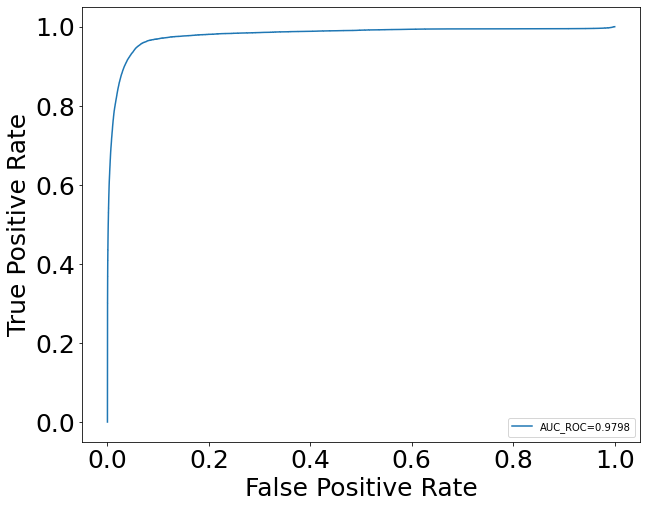

In [ ]:
import matplotlib.pyplot as plt

# Create ROC curve for Blood Vessels
# plt.plot(fpr_bv, tpr_bv)
plt.figure(figsize=(10, 8))
plt.plot(fpr_bv, tpr_bv, label=f"AUC_ROC={auc_bv:0.4f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve for Blood Vessels')
plt.legend(loc=4)

plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.savefig("roc_vb.pdf", bbox_inches="tight" )

plt.show()

In [ ]:
!ls -ltr

total 364517
-rw------- 1 root root       775 May 14  2021 metrics.py
-rw------- 1 root root     20550 Oct 20  2021 utils.py
-rw------- 1 root root      3985 Dec 10  2021 tests.py
-rw------- 1 root root 373119952 Dec 10  2021 new_data_augment.zip
drwx------ 2 root root      4096 Dec 14  2021 files
drwx------ 2 root root      4096 Dec 14  2021 logs
drwx------ 2 root root      4096 Dec 21  2021 files_demo_bv
drwx------ 2 root root      4096 Dec 21  2021 files_demo_fovea
-rw------- 1 root root     58403 Jun 16 05:43 BV_OD_Fovea_Combined.ipynb
drwx------ 2 root root      4096 Jun 16 12:06 __pycache__
drwx------ 3 root root      4096 Jun 16 12:25 new_data_augment
drwx------ 2 root root      4096 Jun 17 11:08 files_fovea_centers
drwx------ 2 root root      4096 Jun 27 07:26 files_demo_od
drwx------ 2 root root      4096 Jun 27 07:26 files_demo_he
drwx------ 2 root root      4096 Jun 27 07:26 files_demo_ex
-rw------- 1 root root     18674 Jun 27 07:35 roc_vb.pdf


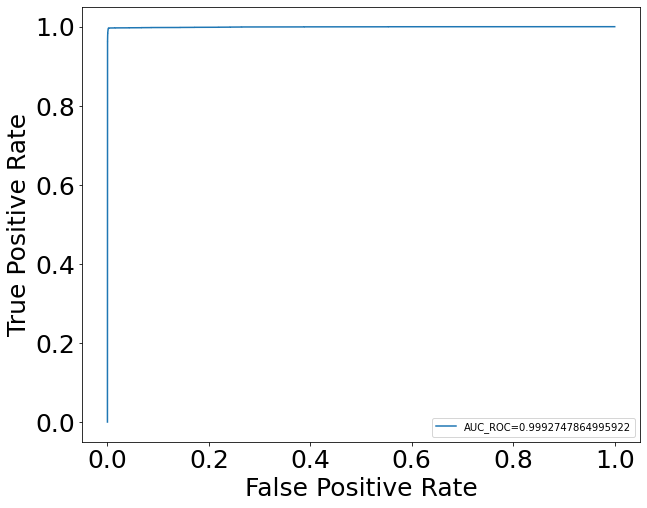

In [ ]:
# Create ROC curve for Blood Vessels
# plt.plot(fpr_bv, tpr_bv)
plt.figure(figsize=(10, 8))

plt.plot(fpr_od, tpr_od, label="AUC_ROC="+str(auc_od))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.title('ROC curve for Optic Disc')
plt.legend(loc=4)

plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.savefig("roc_od.pdf", bbox_inches="tight" )


plt.show()

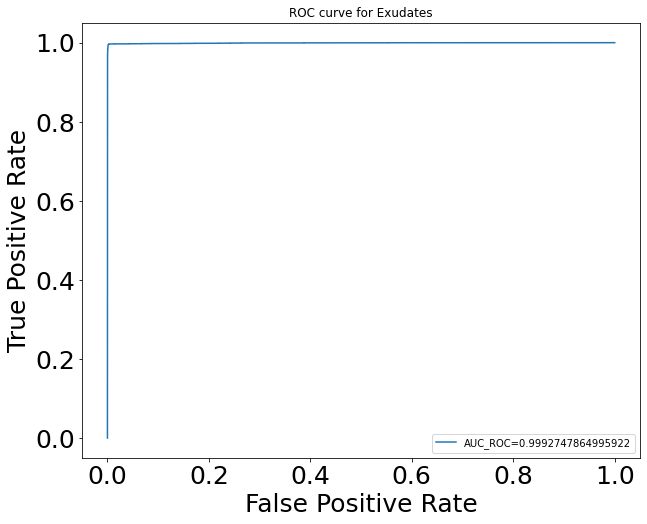

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(fpr_ex, tpr_ex, label="AUC_ROC="+str(auc_ex))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve for Exudates')
plt.legend(loc=4)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.savefig("roc_exudates.pdf", bbox_inches="tight" )

plt.show()

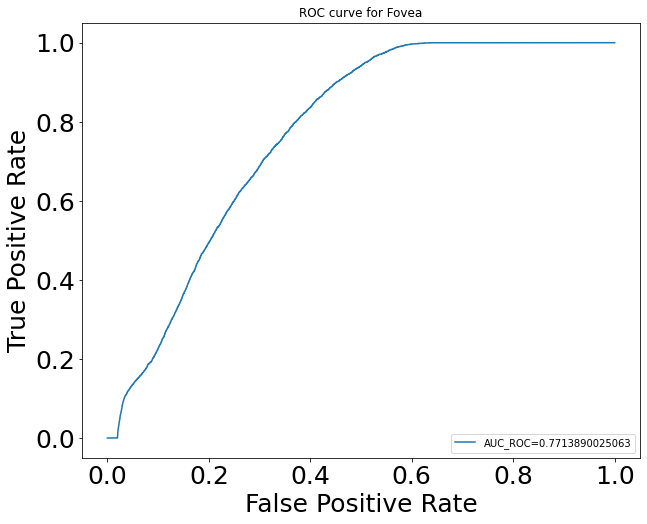

In [ ]:
# Create ROC curve for Blood Vessels
# plt.plot(fpr_bv, tpr_bv)
plt.figure(figsize=(10, 8))

plt.plot(fpr_fovea, tpr_fovea, label="AUC_ROC="+str(auc_fovea))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve for Fovea')
plt.legend(loc=4)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.savefig("roc_fovea.pdf", bbox_inches="tight" )
plt.show()

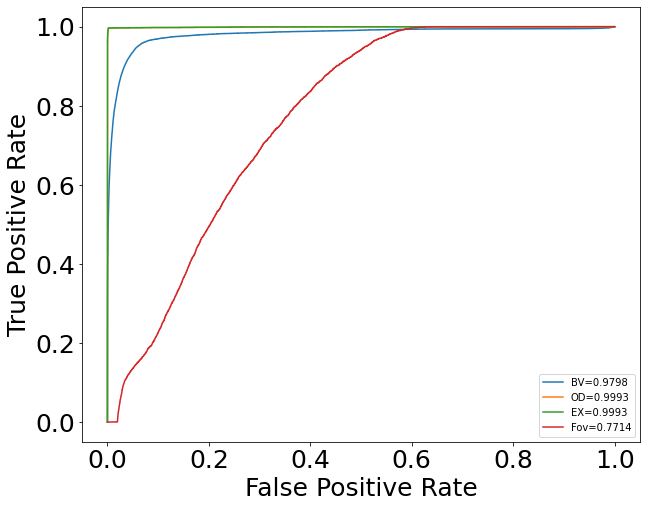

In [ ]:
# Create ROC curve for Blood Vessels
# plt.plot(fpr_bv, tpr_bv)
plt.figure(figsize=(10, 8))

plt.plot(fpr_bv, tpr_bv, label=f'BV={auc_bv:.4f}')
plt.plot(fpr_od, tpr_od, label=f'OD={auc_od:.4f}')
plt.plot(fpr_ex, tpr_ex, label=f'EX={auc_ex:.4f}')
plt.plot(fpr_fovea, tpr_fovea, label=f'Fov={auc_fovea:.4f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve')
plt.legend(loc=4)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.savefig("roc_all.pdf", bbox_inches="tight" )
plt.show()

# Compute Distance from gnd center point to predicted center point for fovea.

In [ ]:
# # GT = (x1, y1)
# # Prediction = (x2, y2)
# # Houghtransform - circles 
# predicted_fovea_features_dict = dict()
# for image each predicted_image:
#     radius, center = cv2.hough_transform(circle)
#     predicted_fovea_features_dict["Filename"] = 
#     predicted_fovea_features_dict["radius"] = radius
#     predicted_fovea_features_dict["predicted_center_x"]
#     predicted_fovea_features_dict["predicted_center_y"]
#     predicted_fovea_features_dict["gt_center_x"]
#     predicted_fovea_features_dict["gt_center_y"]
#     predicted_fovea_features_dict["distance"]

# predicted_fovea_features_df = pd.DataFrame(predicted_fovea_features_dict)

    


In [ ]:
!ls

BV_OD_Fovea_Combined.ipynb  files_fovea_centers   roc_exudates.pdf
files			    logs		  roc_fovea.pdf
files_demo_bv		    metrics.py		  roc_od.pdf
files_demo_ex		    new_data_augment	  roc_vb.pdf
files_demo_fovea	    new_data_augment.zip  tests.py
files_demo_he		    __pycache__		  utils.py
files_demo_od		    roc_all.pdf


In [ ]:
!ls -ltr

total 364623
-rw------- 1 root root       775 May 14  2021 metrics.py
-rw------- 1 root root     20550 Oct 20  2021 utils.py
-rw------- 1 root root      3985 Dec 10  2021 tests.py
-rw------- 1 root root 373119952 Dec 10  2021 new_data_augment.zip
drwx------ 2 root root      4096 Dec 14  2021 files
drwx------ 2 root root      4096 Dec 14  2021 logs
drwx------ 2 root root      4096 Dec 21  2021 files_demo_bv
drwx------ 2 root root      4096 Dec 21  2021 files_demo_fovea
-rw------- 1 root root     58403 Jun 16 05:43 BV_OD_Fovea_Combined.ipynb
drwx------ 2 root root      4096 Jun 16 12:06 __pycache__
drwx------ 3 root root      4096 Jun 16 12:25 new_data_augment
drwx------ 2 root root      4096 Jun 17 11:08 files_fovea_centers
drwx------ 2 root root      4096 Jun 27 07:26 files_demo_od
drwx------ 2 root root      4096 Jun 27 07:26 files_demo_he
drwx------ 2 root root      4096 Jun 27 07:26 files_demo_ex
-rw------- 1 root root     18674 Jun 27 07:35 roc_vb.pdf
-rw------- 1 root root     127

In [ ]:
!pwd

/content/gdrive/MyDrive/1_All_Computations/BV_OD_Fovea_augment
